## Finetuning a network

Tasks

(Note: In this task, if you are adapting the code based on the open-source projects, pls acknowledge the original source in your code files, and also clearly mention it in your report. Also you need to clearly highlight which parts are done by yourself)

In [5]:
import argparse
from utils_ic import load_data, read_jason
from model_ic import NN_Classifier, validation, make_NN, save_checkpoint, load_model, test_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, cuda
from torchvision import datasets, transforms, utils
import torch

# misc functions
def train(
    data_dir,
    cat_names='cat_to_name.json',
    arch='densenet169',
    lr=0.001,
    hidden_units=1024,
    eps=1,
    device='cuda',
    save_dir=None,
    freeze_feature_layers=False,
    optim=None,
    from_scratch=False,
    conv_layers = 5
    ):

    cat_to_name = read_jason(cat_names)

    trainloader, testloader, validloader, train_data = load_data(data_dir)

    val_loss, model = make_NN(
        n_hidden=[hidden_units],
        n_epoch=eps,
        labelsdict=cat_to_name,
        lr=lr,
        device=device,
        model_name=arch,
        trainloader=trainloader,
        validloader=validloader,
        train_data=train_data,
        freeze_feature_layers=freeze_feature_layers,
        optimizer_name=optim,
        from_scratch=from_scratch,
        conv_layers=5
    )
    if save_dir:
        save_checkpoint(model, save_dir + '.pt')

    return val_loss

def save_loss_values(archs, results, path):
    data = {arch: loss for arch, loss in zip(archs, results)}
    lossdf = pd.DataFrame.from_dict(data)
    lossdf.to_csv(path)
    return lossdf

def make_testloader():
    test_dir = 'flowers/test'
    tx = transforms.Compose([transforms.Resize(255), 
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    test_data = datasets.ImageFolder(test_dir, transform=tx)
    return torch.utils.data.DataLoader(test_data, batch_size=32)

'done'

In [25]:
# settable vars
overwriteLossValues = False
data_dir = 'flowers'


## (1) Replace the used base model (densenet169) to another model (refer to https://pytorch.org/vision/0.8/models.html for more types of models). Pls compare the performance of these two models on the validation set.

In [5]:
archs = ['alexnet', 'densenet169'] # vgg11 alexnet densenet169

# init results arr to store results
results = []
for i, arch in enumerate(archs):
    print('training arch {}: {}'.format(i, arch))
    save_dir = 'models/' + arch
    
    # run training and save results
    results.append(train(data_dir, arch=arch, save_dir=save_dir))
    print('\n---------------------------\n')

print('all done')
if overwriteLossValues:
    path = 'results/homework3p2q1.csv'
    save_loss_values(archs, results, path)

training arch 0: alexnet
Epoch: 1/1 -  Training Loss: 4.649 -  Validation Loss: 4.557 -  Validation Accuracy: 0.019
Epoch: 1/1 -  Training Loss: 4.548 -  Validation Loss: 4.547 -  Validation Accuracy: 0.034
Epoch: 1/1 -  Training Loss: 4.554 -  Validation Loss: 4.555 -  Validation Accuracy: 0.034
Epoch: 1/1 -  Training Loss: 4.545 -  Validation Loss: 4.533 -  Validation Accuracy: 0.025
Epoch: 1/1 -  Training Loss: 4.527 -  Validation Loss: 4.518 -  Validation Accuracy: 0.025
Epoch: 1/1 -  Training Loss: 4.553 -  Validation Loss: 4.523 -  Validation Accuracy: 0.034
Epoch: 1/1 -  Training Loss: 4.542 -  Validation Loss: 4.526 -  Validation Accuracy: 0.025
Epoch: 1/1 -  Training Loss: 4.539 -  Validation Loss: 4.515 -  Validation Accuracy: 0.025
Epoch: 1/1 -  Training Loss: 4.553 -  Validation Loss: 4.505 -  Validation Accuracy: 0.025
Epoch: 1/1 -  Training Loss: 4.516 -  Validation Loss: 4.510 -  Validation Accuracy: 0.034
model: alexnet - hidden layers: [1024] - epochs: 1 - lr: 0.001
Ru

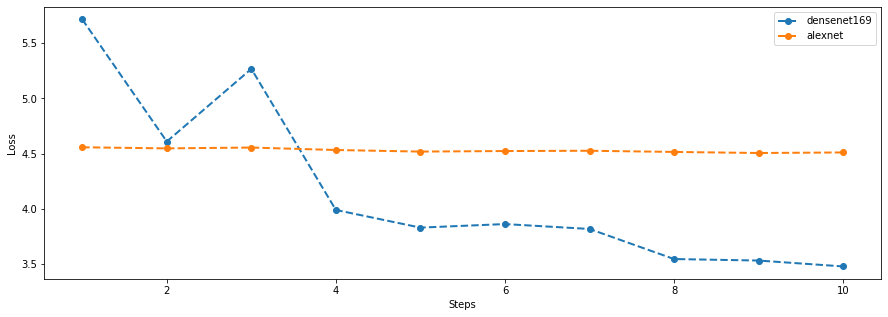

In [6]:
archs = ['densenet169', 'alexnet'] # vgg11 alexnet densenet169
# get the saved loss values
lossdf = pd.read_csv('results/homework3p2q1.csv')
loss_values = lossdf[archs].T.values

# set the plot attributes before plotting the loss values
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Loss')
ax1.set_xlabel('Steps')
fig.set_figheight(5)
fig.set_figwidth(15)
plt.legend(archs) 

# plot the loss values
t = np.arange(1, loss_values.shape[1] + 1, 1)
for result in loss_values:
    plt.plot(t, result, '--o',label='line 1', linewidth=2)
    
plt.legend(archs) 
plt.show() 

# **Analysis**
## *As the steps proceed towards the end of the epoch, the validation loss of densenet seems to decrease much more than that of alexnet.*
## *Densenet may possibly be performing better due to its residual blocks.* 

## *For alexnet, it seems there may be overfitting occuring. It may perform better at a lower learning rate than our default of 0.001. Otherwise, its basic features may just not be powerful enough to learn the features of the dataset well.*<br>

--------------------------------------------------------------------------------------------------------------------------------------------------------------------

## (2) Please try different training methods that use densenet169 as the base model (i.e., training the whole model from scratch, finetuning the model but only updating the top layers, finetuning the whole model), and compare their performance on the validation set. Please also draw the curves of training/validation losses over training steps for these methods, and give your analysis based on the observed curves.

In [7]:
arch = 'densenet169'
changes = ['_frozen_feature_layers', '_from_scratch']

# init results arr to store results
results = []
for i, change in enumerate(changes):
    cuda.empty_cache()
    print('training arch {}: {}'.format(i, arch + change))
    save_dir = 'models/' + arch+change
    
    # run training and save results
    if change == '_frozen_feature_layers':
      result = train(data_dir, arch=arch, save_dir=save_dir, freeze_feature_layers=True)
    elif change == '_from_scratch':
      result = train(data_dir, arch=arch, save_dir=save_dir, from_scratch=True)
    results.append(result)
    print('\n---------------------------\n')

print('all done')
if overwriteLossValues:
    path = 'results/homework3p2q2.csv'
    save_loss_values([arch + change for change in changes], results, path)

training arch 0: densenet169_frozen_feature_layers
Epoch: 1/1 -  Training Loss: 4.682 -  Validation Loss: 4.336 -  Validation Accuracy: 0.073
Epoch: 1/1 -  Training Loss: 4.269 -  Validation Loss: 3.916 -  Validation Accuracy: 0.156
Epoch: 1/1 -  Training Loss: 3.897 -  Validation Loss: 3.359 -  Validation Accuracy: 0.338
Epoch: 1/1 -  Training Loss: 3.409 -  Validation Loss: 2.910 -  Validation Accuracy: 0.376
Epoch: 1/1 -  Training Loss: 2.942 -  Validation Loss: 2.334 -  Validation Accuracy: 0.516
Epoch: 1/1 -  Training Loss: 2.519 -  Validation Loss: 1.974 -  Validation Accuracy: 0.565
Epoch: 1/1 -  Training Loss: 2.371 -  Validation Loss: 1.607 -  Validation Accuracy: 0.680
Epoch: 1/1 -  Training Loss: 2.044 -  Validation Loss: 1.398 -  Validation Accuracy: 0.674
Epoch: 1/1 -  Training Loss: 2.016 -  Validation Loss: 1.266 -  Validation Accuracy: 0.755
Epoch: 1/1 -  Training Loss: 1.720 -  Validation Loss: 1.100 -  Validation Accuracy: 0.766
model: densenet169 - hidden layers: [10

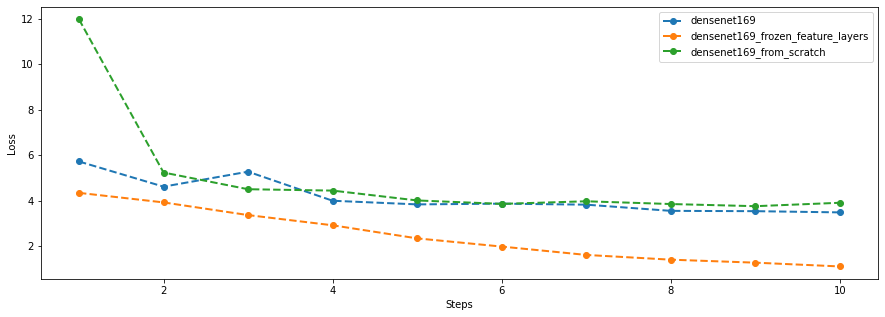

In [14]:
arch = 'densenet169'

# init changes
changes = ['_frozen_feature_layers', '_from_scratch']

# get densenet169 results
lossdf = pd.read_csv('results/homework3p2q1.csv')
loss_values = lossdf[arch].values
loss_values = np.expand_dims(loss_values, axis=1) # add dimension to concat 

# get dense169 with different learning rates layers
lossdf2 = pd.read_csv('results/homework3p2q2.csv')
cols = [arch + change for change in changes]
loss_values2 = lossdf2[cols].values

# concat both results
loss_values = np.concatenate((loss_values,loss_values2), axis=1).T

# set the plot attributes before plotting the loss values
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Loss')
ax1.set_xlabel('Steps')
fig.set_figheight(5)
fig.set_figwidth(15)
labels = [arch] + cols

# plot the loss values
t = np.arange(1, loss_values.shape[1] + 1, 1)
for result in loss_values:
    plt.plot(t, result, '--o',label='line 1', linewidth=2)
plt.legend(labels) 
plt.show() 

# **Analysis**
## *As expected, the densenet trained with transfer learning and frozen feature extraction layers performed much better than its counterpart, one with unfrozen feature extraction layers, another trained without transfer learning.*

## *This establishes the significance of transfer learning (of the original weights) with respect to this dataset. The original weights were very much relevant to this dataset, and are not easily learnt.*<br>

--------------------------------------------------------------------------------------------------------------------------------------------------------------------

# (3) For the model based on densenet169, please also report its performance (when you use the training method of finetuning the model but only updating the top layers) on the testing set.

In [13]:
load_loc = 'models/densenet169_frozen_feature_layers.pt'

model = load_model(load_loc)
testloader = make_testloader()
test_model(model, testloader)

Testing Accuracy: 0.754


# **Analysis**

## *The best performing model(of this experiment) is the densenet169 which was trained with transfer learning, and finetuned only at the top layer. It achieved a testing accuracy of 0.754.*<br>

--------------------------------------------------------------------------------------------------------------------------------------------------------------------

# (4) Please replace the base model to a new model which contains some convolutional layers. You need to write this new model by yourselves, and then report its performance on the validation set. Note, pls try different numbers of convolutional layers for your model, and compare their results, and give analysis for the results. You need to try at least 2 different numbers of conv layers.


In [8]:
arch = 'custom'
layers = [3, 5]

# init results arr to store results
results = []
for i, layer in enumerate(layers):
    print('training custom arch with {} layers'.format(layer))
    save_dir = 'models/' + arch + '_{}_layers'.format(layer)
    
    # run training and save results
    results.append(train(data_dir, arch=arch, save_dir=save_dir, conv_layers=layer))
    print('\n---------------------------\n')

print('all done')
if overwriteLossValues:
    path = 'results/homework3p2q4.csv'

    save_loss_values([arch + '_{}_layers'.format(layer) for layer in layers], results, path)

training custom arch with 3 layers
Epoch: 1/1 -  Training Loss: 4.574 -  Validation Loss: 4.456 -  Validation Accuracy: 0.078
Epoch: 1/1 -  Training Loss: 4.264 -  Validation Loss: 4.008 -  Validation Accuracy: 0.103
Epoch: 1/1 -  Training Loss: 3.990 -  Validation Loss: 3.834 -  Validation Accuracy: 0.113
Epoch: 1/1 -  Training Loss: 3.805 -  Validation Loss: 3.726 -  Validation Accuracy: 0.122
Epoch: 1/1 -  Training Loss: 3.764 -  Validation Loss: 3.432 -  Validation Accuracy: 0.175
Epoch: 1/1 -  Training Loss: 3.643 -  Validation Loss: 3.409 -  Validation Accuracy: 0.162
Epoch: 1/1 -  Training Loss: 3.575 -  Validation Loss: 3.324 -  Validation Accuracy: 0.188
Epoch: 1/1 -  Training Loss: 3.541 -  Validation Loss: 3.357 -  Validation Accuracy: 0.184
Epoch: 1/1 -  Training Loss: 3.454 -  Validation Loss: 3.250 -  Validation Accuracy: 0.178
Epoch: 1/1 -  Training Loss: 3.421 -  Validation Loss: 3.256 -  Validation Accuracy: 0.190
model: custom - hidden layers: [1024] - epochs: 1 - lr:

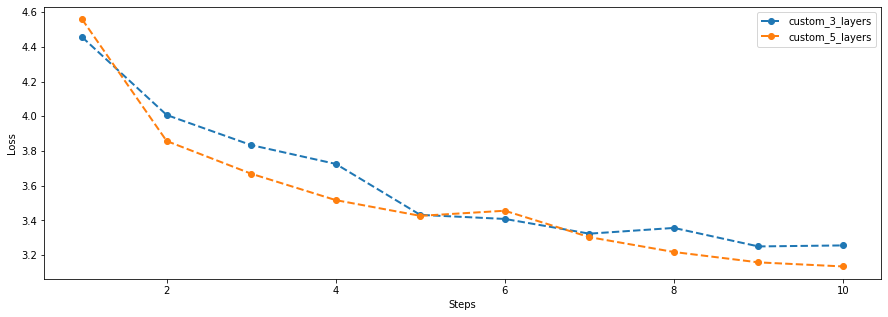

In [14]:
arch = 'custom'
layers = [3, 5]

# get the saved loss values
lossdf = pd.read_csv('results/homework3p2q4.csv')
cols = [arch + '_{}_layers'.format(layer) for layer in layers]
loss_values = lossdf[cols].T.values

# set the plot attributes before plotting the loss values
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Loss')
ax1.set_xlabel('Steps')
fig.set_figheight(5)
fig.set_figwidth(15)

# plot the loss values
t = np.arange(1, loss_values.shape[1] + 1, 1)
for result in loss_values:
    plt.plot(t, result, '--o',label='line 1', linewidth=2)
    
plt.legend(cols) 
plt.show() 

# **Analysis**

## *In this experiment, the custom network that I designed with 5 layers performed better than its counterpart with 3 layers. Nevertheless, their validation acccuracy remains low.*

## *Possible improvements that can be considered are such as:*
- ## *Residual blocks*
- ## *Smaller but long chained kernels*
- ## *Decaying learning rates*
- ## *Alternative optimizing functions*
<br>

--------------------------------------------------------------------------------------------------------------------------------------------------------------------